In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from utils.get_file import GetTV

In [2]:
file_idx = 0
tv = GetTV('tv_images/l-mode')
files = tv.list_files()
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])

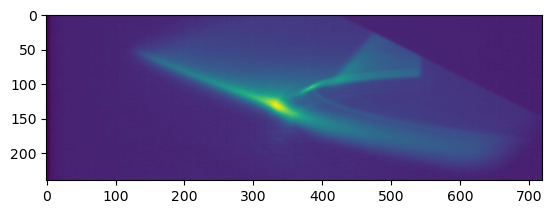

In [7]:
plt.imshow(vid[100])
plt.show()

In [60]:
model = YOLO('yolov8n-seg.pt')

In [61]:
img = np.tile(vid[100], (3,1,1)) / 255
print(img.shape, img.max(), img.min())
cv2.imwrite('temp.jpg', img.transpose(1,2,0)[:,:,::-1]*255)

(3, 240, 720) 0.5098039215686274 0.06274509803921569


True

In [62]:
im2 = cv2.imread('temp.jpg')
orig_img = cv2.resize(im2, (640, 640))
results = model(orig_img)


0: 640x640 1 person, 234.4ms
Speed: 2.9ms preprocess, 234.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


In [63]:
for r in results:
    print(r.masks)

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])
orig_shape: (640, 640)
shape: torch.Size([1, 640, 640])
xy: [array([[        155,           5],
       [        154,           6],
       [         70,           6],
       [         69,           7],
       [         69,           8],
       [         66,          11],
       [         62,          11],
       [         61,          12],
       [         60,          12],
       [         59,          13],
       [         58,          13],
       [         57,          14],
       [         56,          14],
       [         56,          16],
       [         55,          17],
       [         55,          18],
       [         52,          21],
       [         5

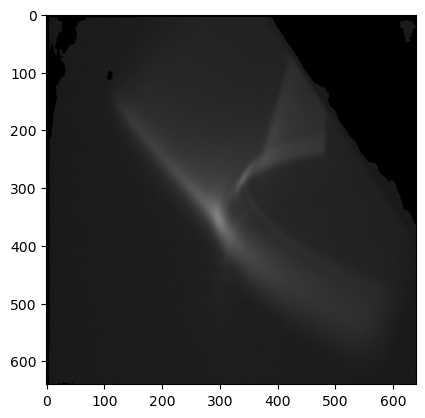

In [64]:
if(results[0].masks is not None):
    # Convert mask to single channel image
    mask_raw = results[0].masks[0].cpu().data.numpy().transpose(1, 2, 0)
    
    # Convert single channel grayscale to 3 channel image
    mask_3channel = cv2.merge((mask_raw,mask_raw,mask_raw))

    # Get the size of the original image (height, width, channels)
    h2, w2, c2 = results[0].orig_img.shape
    
    # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
    mask = cv2.resize(mask_3channel, (w2, h2))

    # Convert BGR to HSV
    hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)

    # Define range of brightness in HSV
    lower_black = np.array([0,0,0])
    upper_black = np.array([0,0,1])

    # Create a mask. Threshold the HSV image to get everything black
    mask = cv2.inRange(mask, lower_black, upper_black)

    # Invert the mask to get everything but black
    mask = cv2.bitwise_not(mask)

    # Apply the mask to the original image
    masked = cv2.bitwise_and(results[0].orig_img, results[0].orig_img, mask=mask)

    # Show the masked part of the image
    plt.imshow(masked)